In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
import chess
from IPython.display import clear_output
import time
from texttable import Texttable


import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType
import matplotlib.pyplot as plt

%matplotlib notebook

In [3]:
def moves_to_arr(moves_string):
    moves = []
    for i in moves_string.split(" "):
        if "." not in i:
            moves.append(i)
    return moves

moves_to_arr_udf = F.udf(moves_to_arr, ArrayType(StringType()))

In [4]:
def generate_base_df(file="chess_dataframe_parquet"):
    df = spark.read.parquet("chess_dataframe_parquet").repartition(200)
    df = df.where(df.Moves.isNotNull())
    df = df.where(df.Result != "*")
    base_df = df.withColumn("MovesArray", moves_to_arr_udf(df["Moves"])).cache()
    
    return base_df

In [5]:
base_df = generate_base_df()
base_df.select("MovesArray").show()

+--------------------+
|          MovesArray|
+--------------------+
|[e4, e6, d4, d5, ...|
|[e4, e5, d4, exd4...|
|[Nf3, d5, d4, Nf6...|
|[d4, d5, c4, c6, ...|
|[d4, Nf6, Bg5, e6...|
|[e4, c5, Nf3, Nf6...|
|[d4, d5, c4, c6, ...|
|[e4, e6, Qe2, d5,...|
|[d4, Nf6, Nf3, g6...|
|[d4, g6, e4, Bg7,...|
|[d4, Nf6, c4, c5,...|
|[e4, e5, Nf3, Nc6...|
|[d4, d5, Nf3, Nf6...|
|[c4, c6, g3, d5, ...|
|[d4, Nf6, Nf3, d5...|
|[d4, d5, c4, e5, ...|
|[e4, c5, g3, h5, ...|
|[e4, c5, Nf3, e6,...|
|[e4, e6, d4, d5, ...|
|[e4, c5, d4, cxd4...|
+--------------------+
only showing top 20 rows



In [6]:
def parse_results(rows):
    results = {"White":0, "Black":0, "Draw": 0}
    for row in rows:
        key = "Draw"
        if row.Result == "1-0":
            key = "White"
        elif row.Result == "0-1":
            key = "Black"
        results[key] = row.winRate
    return results

def visualize_top_moves(top_moves, turn):
    all_results = []
    for i in range(0, len(top_moves), 3):
        move = top_moves[i].move
        results = parse_results(top_moves[i: i+3])
        total = top_moves[i].total
        all_results.append([turn//2 + 1, move, total, results["White"], results["Draw"], results["Black"]])
    
    table = Texttable()
    table.add_rows([['Turn', 'Move', 'Game', 'White', 'Draw', 'Black']]+all_results)
    print(table.draw())

In [7]:
def game(board = chess.Board()):
    board.reset()
    game_df = generate_base_df()
    i = 0
    while not board.is_game_over():
        current_df = game_df.groupBy(game_df.MovesArray.getItem(i).alias("move"), game_df.Result) \
        .count().filter(F.col("move").isNotNull())
        
        current_totals = current_df.groupBy(current_df.move).agg(F.sum("count").alias("total"))
        current_df = current_df.join(current_totals, on=["move"], how="inner")
        top_moves = current_df.withColumn("winRate", F.col("count")/F.col("total")) \
        .orderBy(["total", "winRate", "Result"], ascending=False).take(36)

        #clear_output(wait=False)
        visualize_top_moves(top_moves, i)
        display(board)
        move = input("Move(SAN): ")
        print("\n\n")
        if move == "q":
            break
        while True:
            try:
                uci_move = board.parse_san(move)
                board.push(uci_move)
                break
            except ValueError:
                print("Illegal Move! Try Again.")
                move = input("Move(SAN): ")
            time.sleep(0.5)
        game_df = game_df.where(game_df.MovesArray.getItem(i) == move)
        i += 1
    #clear_output(wait=True)
    print("\n\n")
    print("Game finished.")
    display(board)

+------+------+---------+-------+-------+-------+
| Turn | Move |  Game   | White | Draw  | Black |
+======+======+=========+=======+=======+=======+
| 1    | e4   | 1062634 | 0.472 | 0.097 | 0.431 |
+------+------+---------+-------+-------+-------+
| 1    | d4   | 842911  | 0.475 | 0.101 | 0.424 |
+------+------+---------+-------+-------+-------+
| 1    | Nf3  | 237710  | 0.478 | 0.111 | 0.411 |
+------+------+---------+-------+-------+-------+
| 1    | c4   | 144848  | 0.479 | 0.103 | 0.419 |
+------+------+---------+-------+-------+-------+
| 1    | b3   | 35591   | 0.463 | 0.091 | 0.447 |
+------+------+---------+-------+-------+-------+
| 1    | g3   | 30915   | 0.484 | 0.100 | 0.416 |
+------+------+---------+-------+-------+-------+
| 1    | f4   | 13124   | 0.440 | 0.092 | 0.468 |
+------+------+---------+-------+-------+-------+
| 1    | Nc3  | 12621   | 0.470 | 0.098 | 0.432 |
+------+------+---------+-------+-------+-------+
| 1    | e3   | 9344    | 0.442 | 0.095 | 0.463 |


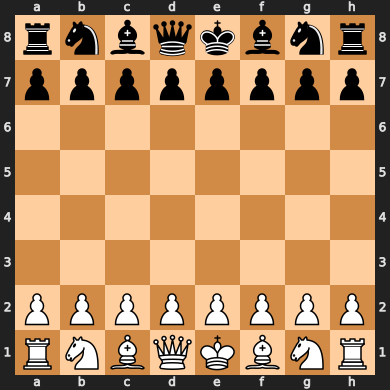

Move(SAN): e4



+------+------+--------+-------+-------+-------+
| Turn | Move |  Game  | White | Draw  | Black |
+======+======+========+=======+=======+=======+
| 1    | c5   | 398752 | 0.474 | 0.093 | 0.433 |
+------+------+--------+-------+-------+-------+
| 1    | e5   | 199592 | 0.467 | 0.107 | 0.425 |
+------+------+--------+-------+-------+-------+
| 1    | e6   | 128305 | 0.474 | 0.097 | 0.429 |
+------+------+--------+-------+-------+-------+
| 1    | c6   | 121713 | 0.470 | 0.104 | 0.426 |
+------+------+--------+-------+-------+-------+
| 1    | d6   | 52073  | 0.479 | 0.089 | 0.432 |
+------+------+--------+-------+-------+-------+
| 1    | d5   | 51346  | 0.464 | 0.099 | 0.437 |
+------+------+--------+-------+-------+-------+
| 1    | g6   | 43875  | 0.467 | 0.084 | 0.449 |
+------+------+--------+-------+-------+-------+
| 1    | Nf6  | 36939  | 0.464 | 0.096 | 0.440 |
+------+------+--------+-------+-------+-------+
| 1    | Nc6  | 16586  | 0.472 | 0.087 | 0.441 |
+--

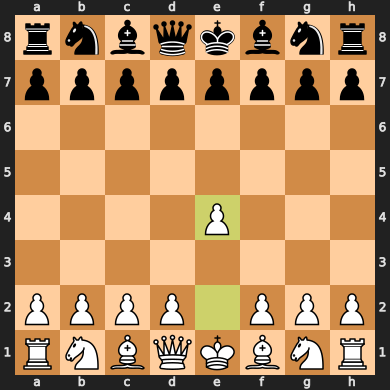

Move(SAN): c5



+------+------+--------+-------+-------+-------+
| Turn | Move |  Game  | White | Draw  | Black |
+======+======+========+=======+=======+=======+
| 2    | Nf3  | 279643 | 0.473 | 0.093 | 0.434 |
+------+------+--------+-------+-------+-------+
| 2    | Nc3  | 50439  | 0.484 | 0.089 | 0.427 |
+------+------+--------+-------+-------+-------+
| 2    | c3   | 24397  | 0.483 | 0.103 | 0.414 |
+------+------+--------+-------+-------+-------+
| 2    | d4   | 18242  | 0.476 | 0.081 | 0.443 |
+------+------+--------+-------+-------+-------+
| 2    | a3   | 3418   | 0.443 | 0.084 | 0.472 |
+------+------+--------+-------+-------+-------+
| 2    | g3   | 3407   | 0.479 | 0.092 | 0.429 |
+------+------+--------+-------+-------+-------+
| 2    | b4   | 2944   | 0.478 | 0.069 | 0.453 |
+------+------+--------+-------+-------+-------+
| 2    | Ne2  | 2919   | 0.493 | 0.095 | 0.413 |
+------+------+--------+-------+-------+-------+
| 2    | d3   | 2691   | 0.467 | 0.097 | 0.436 |
+--

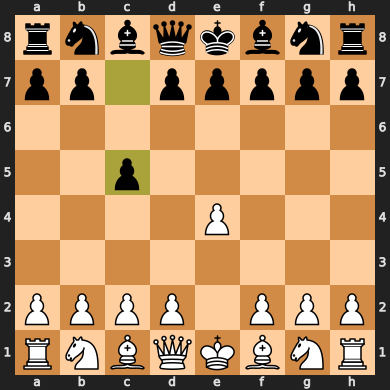

Move(SAN): Nf3



+------+------+--------+-------+-------+-------+
| Turn | Move |  Game  | White | Draw  | Black |
+======+======+========+=======+=======+=======+
| 2    | d6   | 116696 | 0.474 | 0.090 | 0.436 |
+------+------+--------+-------+-------+-------+
| 2    | Nc6  | 74719  | 0.477 | 0.097 | 0.426 |
+------+------+--------+-------+-------+-------+
| 2    | e6   | 61597  | 0.468 | 0.092 | 0.441 |
+------+------+--------+-------+-------+-------+
| 2    | g6   | 16175  | 0.465 | 0.109 | 0.426 |
+------+------+--------+-------+-------+-------+
| 2    | a6   | 5115   | 0.472 | 0.087 | 0.441 |
+------+------+--------+-------+-------+-------+
| 2    | Nf6  | 3378   | 0.432 | 0.093 | 0.475 |
+------+------+--------+-------+-------+-------+
| 2    | Qb6  | 907    | 0.580 | 0.045 | 0.375 |
+------+------+--------+-------+-------+-------+
| 2    | b6   | 473    | 0.467 | 0.068 | 0.465 |
+------+------+--------+-------+-------+-------+
| 2    | d5   | 235    | 0.523 | 0.111 | 0.366 |
+-

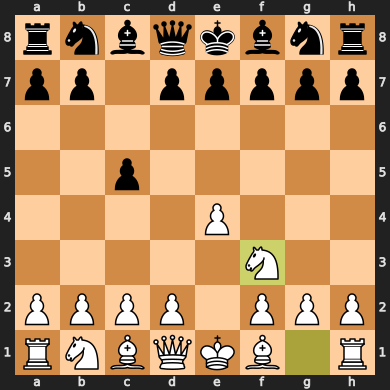

Move(SAN): d6



+------+------+-------+-------+-------+-------+
| Turn | Move | Game  | White | Draw  | Black |
+======+======+=======+=======+=======+=======+
| 3    | d4   | 81833 | 0.474 | 0.085 | 0.441 |
+------+------+-------+-------+-------+-------+
| 3    | Bb5+ | 19067 | 0.476 | 0.108 | 0.417 |
+------+------+-------+-------+-------+-------+
| 3    | c3   | 6310  | 0.482 | 0.089 | 0.428 |
+------+------+-------+-------+-------+-------+
| 3    | Nc3  | 4373  | 0.491 | 0.103 | 0.405 |
+------+------+-------+-------+-------+-------+
| 3    | Bc4  | 1816  | 0.488 | 0.098 | 0.414 |
+------+------+-------+-------+-------+-------+
| 3    | d3   | 1172  | 0.414 | 0.086 | 0.500 |
+------+------+-------+-------+-------+-------+
| 3    | g3   | 657   | 0.434 | 0.099 | 0.467 |
+------+------+-------+-------+-------+-------+
| 3    | b3   | 426   | 0.418 | 0.115 | 0.467 |
+------+------+-------+-------+-------+-------+
| 3    | c4   | 360   | 0.389 | 0.114 | 0.497 |
+------+------+-------+

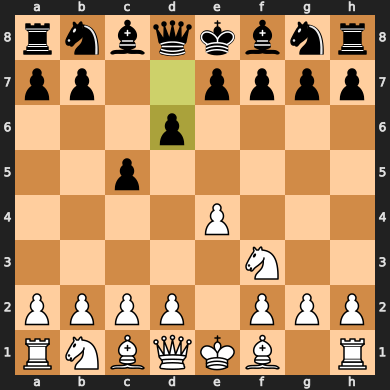

Move(SAN): d4



+------+------+-------+-------+-------+-------+
| Turn | Move | Game  | White | Draw  | Black |
+======+======+=======+=======+=======+=======+
| 3    | cxd4 | 78735 | 0.474 | 0.086 | 0.440 |
+------+------+-------+-------+-------+-------+
| 3    | Nf6  | 3006  | 0.454 | 0.078 | 0.468 |
+------+------+-------+-------+-------+-------+
| 3    | c4   | 42    | 0.619 | 0.167 | 0.214 |
+------+------+-------+-------+-------+-------+
| 3    | Nc6  | 16    | 0.429 | 0     | 0.500 |
+------+------+-------+-------+-------+-------+
| 3    | Bg4  | 7     | 0.429 | 0.286 | 0     |
+------+------+-------+-------+-------+-------+
| 3    | Nd7  | 7     | 0     | 0     | 0.500 |
+------+------+-------+-------+-------+-------+
| 3    | e6   | 4     | 0.667 | 0.250 | 0     |
+------+------+-------+-------+-------+-------+
| 3    | Bd7  | 3     | 0.500 | 0     | 0.333 |
+------+------+-------+-------+-------+-------+
| 3    | Qc7  | 2     | 1     | 0     | 0.500 |
+------+------+-------+

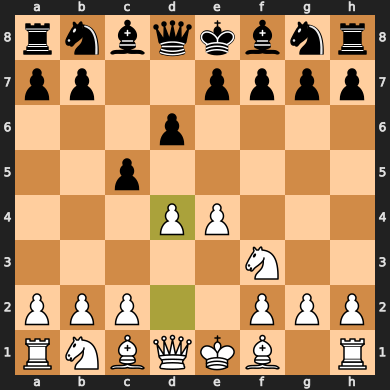

Move(SAN): cxd4



+------+------+-------+-------+-------+-------+
| Turn | Move | Game  | White | Draw  | Black |
+======+======+=======+=======+=======+=======+
| 4    | Nxd4 | 70703 | 0.473 | 0.085 | 0.442 |
+------+------+-------+-------+-------+-------+
| 4    | Qxd4 | 7026  | 0.501 | 0.092 | 0.407 |
+------+------+-------+-------+-------+-------+
| 4    | c3   | 857   | 0.410 | 0.060 | 0.531 |
+------+------+-------+-------+-------+-------+
| 4    | Bb5+ | 65    | 0.308 | 0.062 | 0.631 |
+------+------+-------+-------+-------+-------+
| 4    | e5   | 49    | 0.571 | 0.082 | 0.347 |
+------+------+-------+-------+-------+-------+
| 4    | Bc4  | 12    | 0.500 | 0     | 0.833 |
+------+------+-------+-------+-------+-------+
| 4    | Qd3  | 10    | 0     | 0.100 | 0.667 |
+------+------+-------+-------+-------+-------+
| 4    | Nc3  | 3     | 0.333 | 0     | 0.667 |
+------+------+-------+-------+-------+-------+
| 4    | c4   | 3     | 1     | 0     | 0     |
+------+------+------

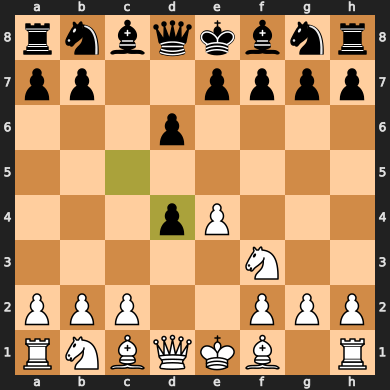

Move(SAN): Nxd4



+------+------+-------+-------+-------+-------+
| Turn | Move | Game  | White | Draw  | Black |
+======+======+=======+=======+=======+=======+
| 4    | Nf6  | 68190 | 0.473 | 0.086 | 0.441 |
+------+------+-------+-------+-------+-------+
| 4    | e5   | 923   | 0.390 | 0.082 | 0.528 |
+------+------+-------+-------+-------+-------+
| 4    | a6   | 780   | 0.515 | 0.073 | 0.412 |
+------+------+-------+-------+-------+-------+
| 4    | e6   | 427   | 0.410 | 0.042 | 0.548 |
+------+------+-------+-------+-------+-------+
| 4    | Nc6  | 276   | 0.583 | 0.094 | 0.322 |
+------+------+-------+-------+-------+-------+
| 4    | g6   | 76    | 0.513 | 0.105 | 0.382 |
+------+------+-------+-------+-------+-------+
| 4    | f6   | 16    | 0.562 | 0.125 | 0.312 |
+------+------+-------+-------+-------+-------+
| 4    | Nd7  | 4     | 1     | 0     | 0.500 |
+------+------+-------+-------+-------+-------+
| 4    | h6   | 1     | 1     | 0     | 1     |
+------+------+------

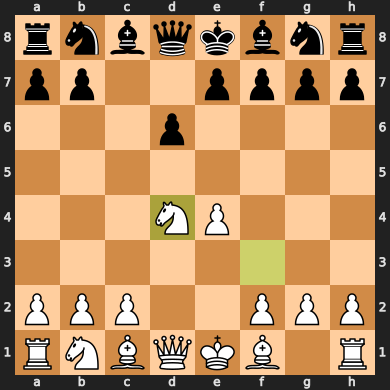

Move(SAN): Nf6



+------+------+-------+-------+-------+-------+
| Turn | Move | Game  | White | Draw  | Black |
+======+======+=======+=======+=======+=======+
| 5    | Nc3  | 64454 | 0.472 | 0.084 | 0.444 |
+------+------+-------+-------+-------+-------+
| 5    | f3   | 3180  | 0.504 | 0.121 | 0.375 |
+------+------+-------+-------+-------+-------+
| 5    | Bd3  | 374   | 0.433 | 0.126 | 0.441 |
+------+------+-------+-------+-------+-------+
| 5    | Bc4  | 75    | 0.400 | 0.093 | 0.507 |
+------+------+-------+-------+-------+-------+
| 5    | Bb5+ | 20    | 0.400 | 0.100 | 0.500 |
+------+------+-------+-------+-------+-------+
| 5    | e5   | 18    | 0.667 | 0.111 | 0.222 |
+------+------+-------+-------+-------+-------+
| 5    | c3   | 17    | 0.412 | 0.176 | 0.412 |
+------+------+-------+-------+-------+-------+
| 5    | Nd2  | 12    | 0.750 | 0.167 | 0.083 |
+------+------+-------+-------+-------+-------+
| 5    | c4   | 7     | 0.429 | 0     | 0.429 |
+------+------+-------

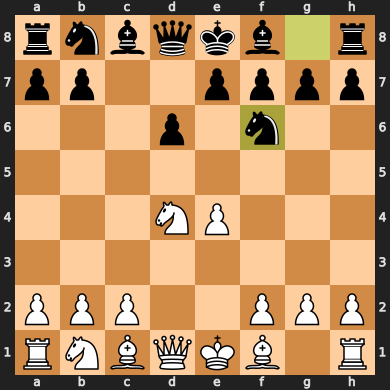

Move(SAN): Nc3



+------+------+-------+-------+-------+-------+
| Turn | Move | Game  | White | Draw  | Black |
+======+======+=======+=======+=======+=======+
| 5    | a6   | 42258 | 0.478 | 0.083 | 0.439 |
+------+------+-------+-------+-------+-------+
| 5    | g6   | 12368 | 0.470 | 0.080 | 0.450 |
+------+------+-------+-------+-------+-------+
| 5    | Nc6  | 7691  | 0.446 | 0.093 | 0.461 |
+------+------+-------+-------+-------+-------+
| 5    | e6   | 903   | 0.492 | 0.080 | 0.429 |
+------+------+-------+-------+-------+-------+
| 5    | e5   | 725   | 0.412 | 0.097 | 0.491 |
+------+------+-------+-------+-------+-------+
| 5    | Bd7  | 421   | 0.439 | 0.095 | 0.466 |
+------+------+-------+-------+-------+-------+
| 5    | Nbd7 | 25    | 0.480 | 0.200 | 0.320 |
+------+------+-------+-------+-------+-------+
| 5    | h6   | 24    | 0.250 | 0.167 | 0.583 |
+------+------+-------+-------+-------+-------+
| 5    | a5   | 21    | 0.476 | 0.048 | 0.476 |
+------+------+-------

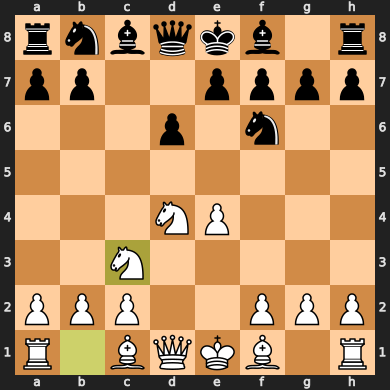

Move(SAN): a6



+------+------+-------+-------+-------+-------+
| Turn | Move | Game  | White | Draw  | Black |
+======+======+=======+=======+=======+=======+
| 6    | Bg5  | 11581 | 0.472 | 0.072 | 0.456 |
+------+------+-------+-------+-------+-------+
| 6    | Be3  | 6723  | 0.482 | 0.100 | 0.418 |
+------+------+-------+-------+-------+-------+
| 6    | Bc4  | 5252  | 0.495 | 0.064 | 0.441 |
+------+------+-------+-------+-------+-------+
| 6    | Be2  | 4251  | 0.467 | 0.085 | 0.448 |
+------+------+-------+-------+-------+-------+
| 6    | h3   | 3859  | 0.468 | 0.087 | 0.445 |
+------+------+-------+-------+-------+-------+
| 6    | f3   | 2624  | 0.439 | 0.089 | 0.471 |
+------+------+-------+-------+-------+-------+
| 6    | f4   | 1604  | 0.486 | 0.094 | 0.421 |
+------+------+-------+-------+-------+-------+
| 6    | g3   | 1533  | 0.459 | 0.108 | 0.434 |
+------+------+-------+-------+-------+-------+
| 6    | a3   | 1016  | 0.565 | 0.092 | 0.344 |
+------+------+-------+

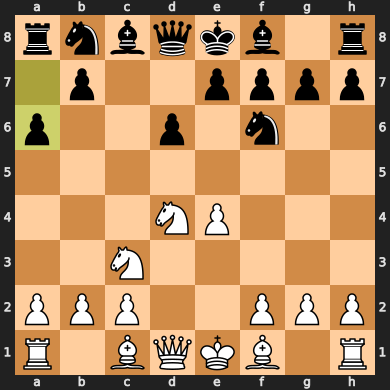

Move(SAN): Bg5



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 6    | e6   | 7829 | 0.468 | 0.072 | 0.460 |
+------+------+------+-------+-------+-------+
| 6    | Nbd7 | 3314 | 0.475 | 0.073 | 0.452 |
+------+------+------+-------+-------+-------+
| 6    | e5   | 266  | 0.541 | 0.068 | 0.391 |
+------+------+------+-------+-------+-------+
| 6    | Nc6  | 93   | 0.516 | 0.043 | 0.441 |
+------+------+------+-------+-------+-------+
| 6    | Qb6  | 19   | 0.474 | 0.053 | 0.474 |
+------+------+------+-------+-------+-------+
| 6    | Bd7  | 14   | 0.500 | 0     | 0.286 |
+------+------+------+-------+-------+-------+
| 6    | h6   | 12   | 0.500 | 0     | 0.500 |
+------+------+------+-------+-------+-------+
| 6    | b5   | 8    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+
| 6    | Qc7  | 5    | 0.200 | 0.200 | 0.600 |
+------+------+------+-------+-------+----

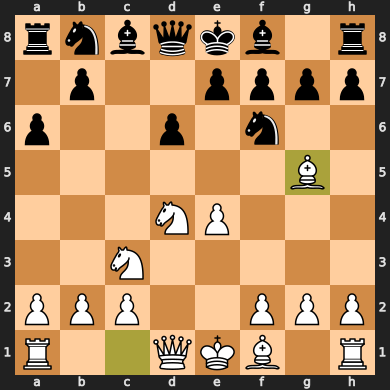

Move(SAN): e6



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 7    | f4   | 5842 | 0.467 | 0.074 | 0.459 |
+------+------+------+-------+-------+-------+
| 7    | Qf3  | 572  | 0.493 | 0.073 | 0.434 |
+------+------+------+-------+-------+-------+
| 7    | Qe2  | 552  | 0.525 | 0.071 | 0.404 |
+------+------+------+-------+-------+-------+
| 7    | Qd2  | 381  | 0.428 | 0.052 | 0.520 |
+------+------+------+-------+-------+-------+
| 7    | f3   | 282  | 0.447 | 0.046 | 0.507 |
+------+------+------+-------+-------+-------+
| 7    | Bc4  | 70   | 0.371 | 0.043 | 0.586 |
+------+------+------+-------+-------+-------+
| 7    | Bd3  | 58   | 0.431 | 0.121 | 0.448 |
+------+------+------+-------+-------+-------+
| 7    | Be2  | 26   | 0.423 | 0.077 | 0.500 |
+------+------+------+-------+-------+-------+
| 7    | Bxf6 | 14   | 0.357 | 0     | 0.692 |
+------+------+------+-------+-------+-----

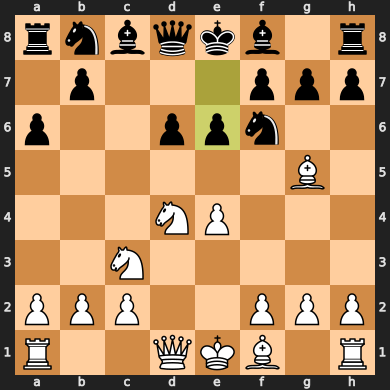

Move(SAN): f4



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 7    | Be7  | 1835 | 0.500 | 0.065 | 0.435 |
+------+------+------+-------+-------+-------+
| 7    | h6   | 1466 | 0.443 | 0.072 | 0.484 |
+------+------+------+-------+-------+-------+
| 7    | Qb6  | 986  | 0.428 | 0.115 | 0.457 |
+------+------+------+-------+-------+-------+
| 7    | Nbd7 | 736  | 0.485 | 0.060 | 0.455 |
+------+------+------+-------+-------+-------+
| 7    | Qc7  | 418  | 0.522 | 0.057 | 0.421 |
+------+------+------+-------+-------+-------+
| 7    | b5   | 252  | 0.349 | 0.056 | 0.595 |
+------+------+------+-------+-------+-------+
| 7    | Nc6  | 129  | 0.512 | 0.085 | 0.403 |
+------+------+------+-------+-------+-------+
| 7    | Bd7  | 18   | 0.444 | 0.167 | 0.389 |
+------+------+------+-------+-------+-------+
| 7    | Ke7  | 1    | 1     | 0     | 1     |
+------+------+------+-------+-------+-----

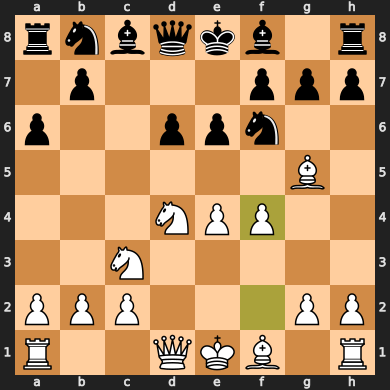

Move(SAN): Be7



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 8    | Qf3  | 1691 | 0.496 | 0.064 | 0.439 |
+------+------+------+-------+-------+-------+
| 8    | Qe2  | 111  | 0.559 | 0.063 | 0.378 |
+------+------+------+-------+-------+-------+
| 8    | Qd2  | 12   | 0.333 | 0.167 | 0.500 |
+------+------+------+-------+-------+-------+
| 8    | Bd3  | 9    | 0.667 | 0     | 0.333 |
+------+------+------+-------+-------+-------+
| 8    | Be2  | 3    | 0.500 | 0.500 | 0     |
+------+------+------+-------+-------+-------+
| 8    | g4   | 2    | 1     | 0     | 0.500 |
+------+------+------+-------+-------+-------+
| 8    | Bh4  | 1    | 1     | 0     | 1     |
+------+------+------+-------+-------+-------+
| 8    | Bxf6 | 1    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+


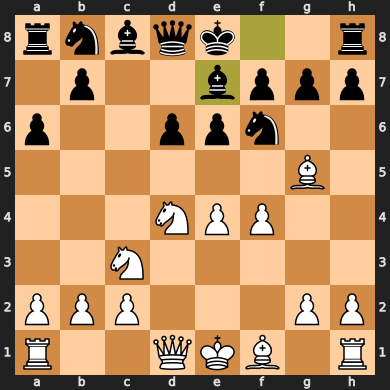

Move(SAN): Qf3



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 8    | Qc7  | 949  | 0.515 | 0.063 | 0.421 |
+------+------+------+-------+-------+-------+
| 8    | h6   | 429  | 0.459 | 0.072 | 0.469 |
+------+------+------+-------+-------+-------+
| 8    | Nbd7 | 170  | 0.582 | 0.035 | 0.382 |
+------+------+------+-------+-------+-------+
| 8    | O-O  | 43   | 0.395 | 0.093 | 0.512 |
+------+------+------+-------+-------+-------+
| 8    | Qa5  | 35   | 0.343 | 0.114 | 0.543 |
+------+------+------+-------+-------+-------+
| 8    | Nfd7 | 31   | 0.387 | 0.129 | 0.484 |
+------+------+------+-------+-------+-------+
| 8    | Qb6  | 20   | 0.400 | 0     | 0.750 |
+------+------+------+-------+-------+-------+
| 8    | Nc6  | 8    | 1     | 0     | 1     |
+------+------+------+-------+-------+-------+
| 8    | b5   | 1    | 1     | 0     | 0     |
+------+------+------+-------+-------+----

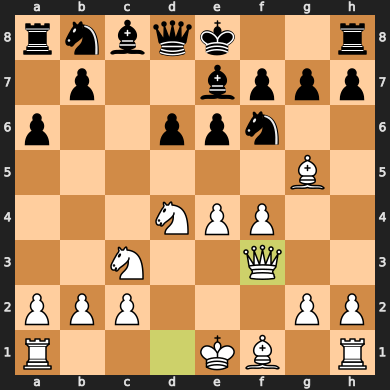

Move(SAN): Qc7



+------+-------+------+-------+-------+-------+
| Turn | Move  | Game | White | Draw  | Black |
+======+=======+======+=======+=======+=======+
| 9    | O-O-O | 932  | 0.515 | 0.062 | 0.423 |
+------+-------+------+-------+-------+-------+
| 9    | Bd3   | 8    | 0.250 | 0.250 | 0.500 |
+------+-------+------+-------+-------+-------+
| 9    | g4    | 7    | 0.500 | 0     | 0.143 |
+------+-------+------+-------+-------+-------+
| 9    | Be2   | 2    | 0     | 0     | 0.500 |
+------+-------+------+-------+-------+-------+


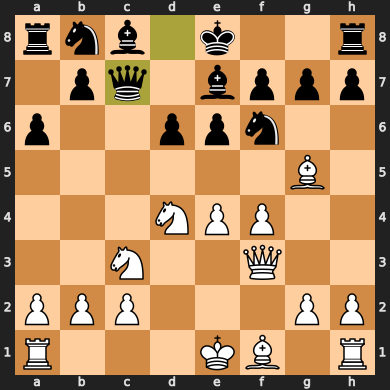

Move(SAN): O-O-O



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 9    | Nbd7 | 690  | 0.507 | 0.070 | 0.423 |
+------+------+------+-------+-------+-------+
| 9    | h6   | 86   | 0.384 | 0.058 | 0.558 |
+------+------+------+-------+-------+-------+
| 9    | Bd7  | 50   | 0.700 | 0.040 | 0.260 |
+------+------+------+-------+-------+-------+
| 9    | O-O  | 43   | 0.465 | 0.047 | 0.488 |
+------+------+------+-------+-------+-------+
| 9    | Nc6  | 35   | 0.543 | 0.029 | 0.429 |
+------+------+------+-------+-------+-------+
| 9    | b5   | 28   | 0.821 | 0     | 0.179 |
+------+------+------+-------+-------+-------+


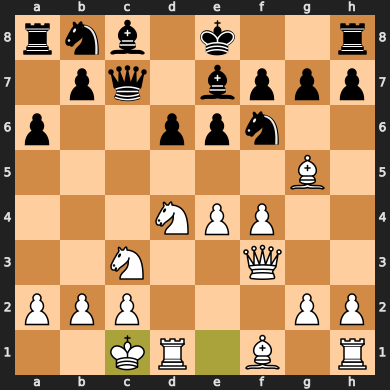

Move(SAN): Nbd7



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 10   | g4   | 439  | 0.508 | 0.068 | 0.424 |
+------+------+------+-------+-------+-------+
| 10   | Bd3  | 180  | 0.539 | 0.083 | 0.378 |
+------+------+------+-------+-------+-------+
| 10   | Kb1  | 20   | 0.550 | 0     | 0.350 |
+------+------+------+-------+-------+-------+
| 10   | Kb1  | 20   | 0.300 | 0.100 | 0.583 |
+------+------+------+-------+-------+-------+
| 10   | Be2  | 12   | 0.500 | 0     | 0.833 |
+------+------+------+-------+-------+-------+
| 10   | Bxf6 | 6    | 0.800 | 0     | 0.500 |
+------+------+------+-------+-------+-------+
| 10   | Rd2  | 5    | 0     | 1     | 1     |
+------+------+------+-------+-------+-------+


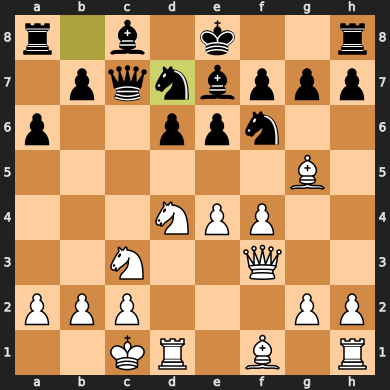

Move(SAN): g4



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 10   | b5   | 314  | 0.545 | 0.073 | 0.382 |
+------+------+------+-------+-------+-------+
| 10   | h6   | 84   | 0.524 | 0.060 | 0.417 |
+------+------+------+-------+-------+-------+
| 10   | O-O  | 34   | 0.235 | 0.059 | 0.706 |
+------+------+------+-------+-------+-------+
| 10   | Rb8  | 6    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+


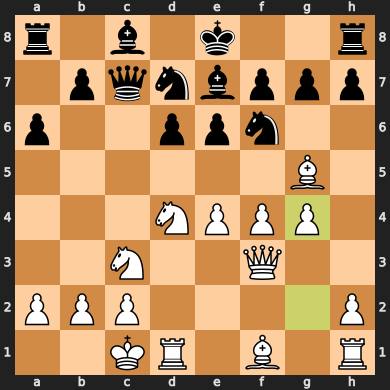

Move(SAN): b5



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 11   | Bxf6 | 285  | 0.547 | 0.067 | 0.386 |
+------+------+------+-------+-------+-------+
| 11   | a3   | 17   | 0.647 | 0.118 | 0.235 |
+------+------+------+-------+-------+-------+
| 11   | Bg2  | 7    | 0.429 | 0.286 | 0.286 |
+------+------+------+-------+-------+-------+
| 11   | Bd3  | 3    | 0.333 | 0     | 1     |
+------+------+------+-------+-------+-------+
| 11   | Bh4  | 1    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+


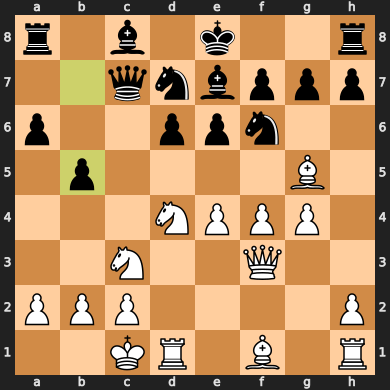

Move(SAN): Bxf6



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 11   | Nxf6 | 247  | 0.522 | 0.077 | 0.401 |
+------+------+------+-------+-------+-------+
| 11   | gxf6 | 26   | 0.750 | 0     | 0.308 |
+------+------+------+-------+-------+-------+
| 11   | Bxf6 | 12   | 0     | 0     | 0.250 |
+------+------+------+-------+-------+-------+


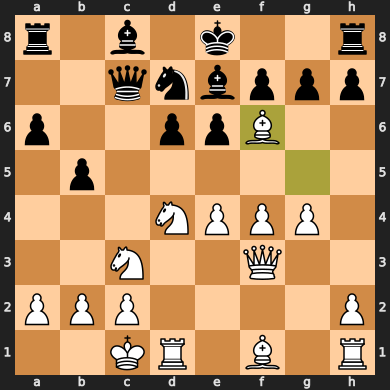

Move(SAN): Nxf6



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 12   | g5   | 247  | 0.522 | 0.077 | 0.401 |
+------+------+------+-------+-------+-------+


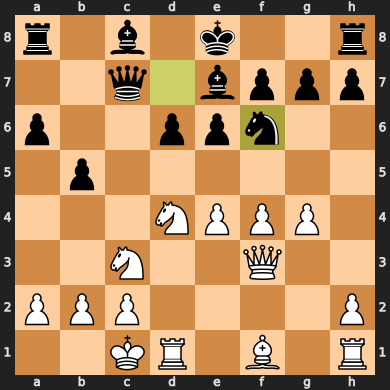

Move(SAN): g5



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 12   | Nd7  | 246  | 0.524 | 0.073 | 0.402 |
+------+------+------+-------+-------+-------+


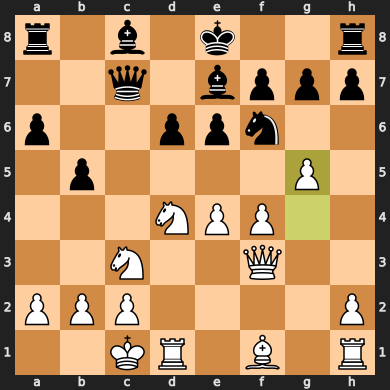

Move(SAN): Nd7



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 13   | f5   | 213  | 0.516 | 0.075 | 0.408 |
+------+------+------+-------+-------+-------+
| 13   | h4   | 19   | 0.526 | 0.105 | 0.368 |
+------+------+------+-------+-------+-------+
| 13   | a3   | 10   | 1     | 0     | 0.400 |
+------+------+------+-------+-------+-------+
| 13   | Bg2  | 1    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+


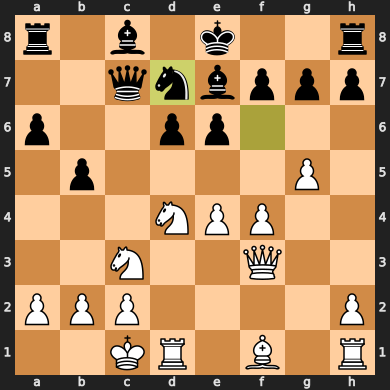

Move(SAN): f5



+------+-------+------+-------+-------+-------+
| Turn | Move  | Game | White | Draw  | Black |
+======+=======+======+=======+=======+=======+
| 13   | O-O   | 102  | 0.529 | 0.108 | 0.363 |
+------+-------+------+-------+-------+-------+
| 13   | Bxg5+ | 73   | 0.479 | 0.055 | 0.466 |
+------+-------+------+-------+-------+-------+
| 13   | Nc5   | 29   | 0.552 | 0.034 | 0.414 |
+------+-------+------+-------+-------+-------+
| 13   | Ne5   | 7    | 1     | 0     | 0.571 |
+------+-------+------+-------+-------+-------+
| 13   | e5    | 1    | 1     | 0     | 0     |
+------+-------+------+-------+-------+-------+


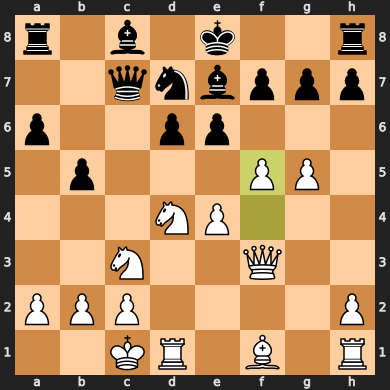

Move(SAN): O-O



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 14   | Rg1  | 38   | 0.579 | 0.026 | 0.395 |
+------+------+------+-------+-------+-------+
| 14   | h4   | 20   | 0.550 | 0.200 | 0.250 |
+------+------+------+-------+-------+-------+
| 14   | f6   | 18   | 0.333 | 0.167 | 0.500 |
+------+------+------+-------+-------+-------+
| 14   | fxe6 | 11   | 0.636 | 0.091 | 0.273 |
+------+------+------+-------+-------+-------+
| 14   | Qh5  | 4    | 0.500 | 0.250 | 0     |
+------+------+------+-------+-------+-------+
| 14   | Qg3  | 4    | 0     | 0.250 | 0.250 |
+------+------+------+-------+-------+-------+
| 14   | Kb1  | 3    | 1     | 0     | 0.333 |
+------+------+------+-------+-------+-------+
| 14   | Bh3  | 1    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+


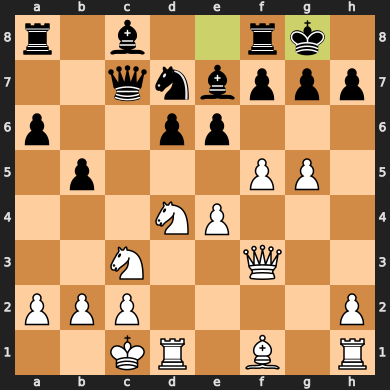

Move(SAN): Rg1



+------+------+------+-------+-------+-------+
| Turn | Move | Game | White | Draw  | Black |
+======+======+======+=======+=======+=======+
| 14   | b4   | 27   | 0.600 | 0     | 0.333 |
+------+------+------+-------+-------+-------+
| 14   | Ne5  | 5    | 0.500 | 0.500 | 0.400 |
+------+------+------+-------+-------+-------+
| 14   | Bb7  | 2    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+
| 14   | e5   | 1    | 0     | 0     | 1     |
+------+------+------+-------+-------+-------+


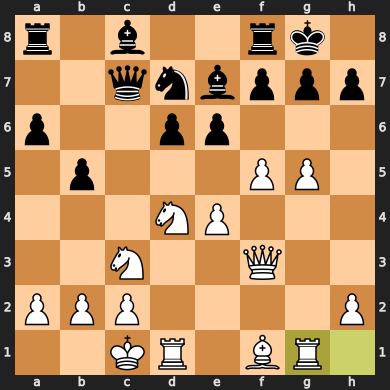

Move(SAN): b4



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 15   | Nce2 | 22   | 0.600 | 0    | 0.318 |
+------+------+------+-------+------+-------+
| 15   | f6   | 5    | 0     | 0    | 0.400 |
+------+------+------+-------+------+-------+


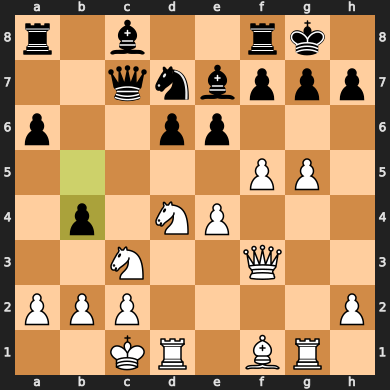

Move(SAN): Nce2



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 15   | e5   | 19   | 1     | 0    | 0.263 |
+------+------+------+-------+------+-------+
| 15   | Kh8  | 1    | 0     | 0    | 1     |
+------+------+------+-------+------+-------+


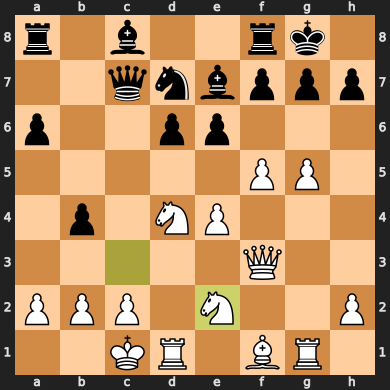

Move(SAN): e5



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 16   | f6   | 15   | 0.750 | 0    | 0.267 |
+------+------+------+-------+------+-------+
| 16   | Nb3  | 4    | 0     | 0    | 0.250 |
+------+------+------+-------+------+-------+


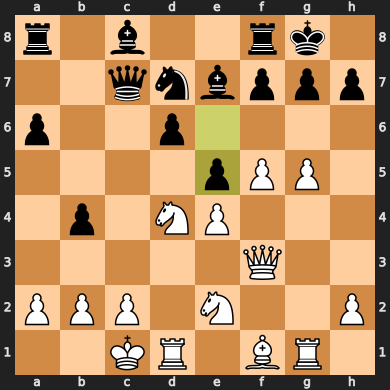

Move(SAN): f6



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 16   | exd4 | 14   | 1     | 0    | 0.286 |
+------+------+------+-------+------+-------+


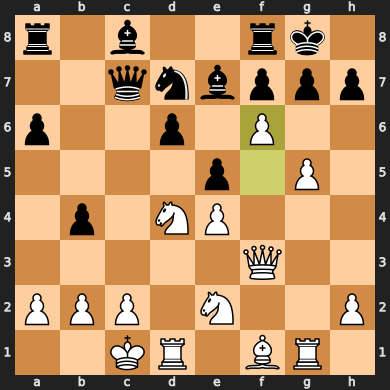

Move(SAN): exd4



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 17   | fxe7 | 14   | 0.714 | 0    | 0.286 |
+------+------+------+-------+------+-------+


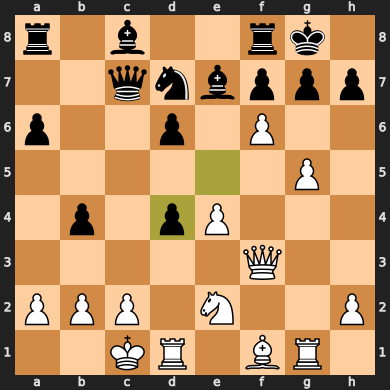

Move(SAN): fxe7



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 17   | Re8  | 14   | 0.714 | 0    | 0.286 |
+------+------+------+-------+------+-------+


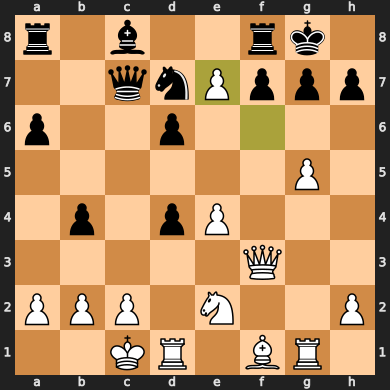

Move(SAN): Re8



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 18   | Nxd4 | 13   | 1     | 0    | 0.308 |
+------+------+------+-------+------+-------+


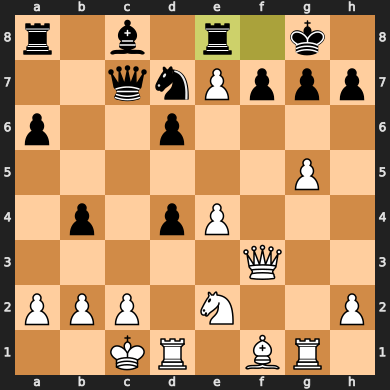

Move(SAN): Nxd4



+------+------+------+-------+------+-------+
| Turn | Move | Game | White | Draw | Black |
+======+======+======+=======+======+=======+
| 18   | Ne5  | 12   | 0.750 | 0    | 1     |
+------+------+------+-------+------+-------+


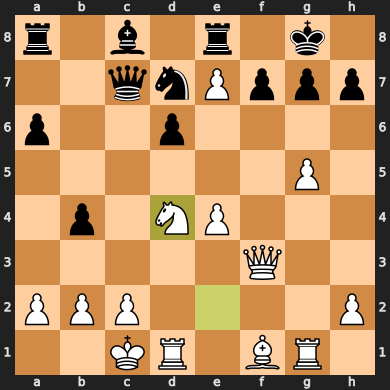

Move(SAN): Ne5





In [ ]:
game()